In [32]:
import YOLOtrack11
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
from YOLOtrack11.results import ZAxisResults as Results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle
from importlib import reload
# from ultralytics.utils.metrics import box_iou
from scipy.optimize import linear_sum_assignment
import torch
from ultralytics.utils import ops
np.s_

def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
    # print(data)
    cls = data[0]
    bboxes = data[1:5].T
    z = data[5]
    kpts = data[6:].T*512
    # print(bboxes)
    
    return plot_result(ax,path, cls,bboxes,z,kpts)


def plot_result(ax,path,cls,bboxes,z,kpts, conf=None):
    is_conf = conf is not None
    if not is_conf:
         conf = np.zeros_like(cls)
    img = np.array(PIL.Image.open(path))
    ax.imshow(img,cmap="grey",vmin=1.95e4,vmax=2.05e4)
    ax.axis("off")
    for bbox,z_value,kpt,c in zip(bboxes,z,kpts,conf):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
        circle = Circle(kpt,1, facecolor="red",edgecolor="red")
        tx,ty = rect.get_xy()
        tx+=6
        ty-=12
        ax.text(tx,ty,f"z={z_value:.3f}" + (f", {c*100:.0f}%" if is_conf else ""),fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))
        ax.add_patch(rect)
        ax.add_patch(circle)
    return bboxes,z

      
def match_predictions(pred_bboxes, gt_bboxes, pred_classes, true_classes,threshold):

        iou = box_iou(torch.Tensor(gt_bboxes), torch.Tensor(pred_bboxes))

        correct = np.zeros((pred_classes.shape[0])).astype(bool)
        gt_pred_matches = np.zeros((true_classes.shape[0],pred_classes.shape[0] ), dtype=bool)
        # LxD matrix where L - labels (rows), D - detections (columns)
        correct_class = true_classes[:, None] == pred_classes
        iou = iou * correct_class  # zero out the wrong classes
        iou = iou.cpu().numpy()

        cost_matrix = iou * (iou >= threshold)
        if cost_matrix.any():
            labels_idx, detections_idx = linear_sum_assignment(cost_matrix, maximize=True)
            valid = cost_matrix[labels_idx, detections_idx] > 0
            if valid.any():
                correct[detections_idx[valid]] = True
                gt_pred_matches[labels_idx,detections_idx] = valid

        return correct, gt_pred_matches
def box_iou(box1, box2, eps=1e-7):

    (a1, a2), (b1, b2) = box1.float().unsqueeze(1).chunk(2, 2), box2.float().unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [2]:
# reload(results)
model = YOLOtrack11.YOLOtrack11("../ultralytics/runs/pose/train23/weights/last.pt")
# print(model.model.model)
print("loaded")
dataset_path = "../ultralytics/data_gen/Dataset_hard/images/test"
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]



loaded


(512, 512)

0: 512x512 49 bs, 3.1ms
Speed: 0.3ms preprocess, 3.1ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 512)


gt  : [  0.0082961   0.0063816   0.0051053     0.21634    0.059349     0.92087     0.01404     0.97958      0.7709     0.96682    0.029355     0.74537     0.95788     0.20613     0.14167     0.72176     0.22655     0.65092      0.3529    0.033823     0.30951     0.64199     0.56669     0.37971     0.68794     0.15763
     0.87428      0.1538     0.80153     0.18507     0.11806     0.52457     0.41736     0.54116     0.69368     0.20932     0.97192     0.56158     0.90874     0.52265     0.93172     0.83791     0.92853     0.74856     0.84365     0.48883     0.50734     0.69815     0.79451]
yolo: [     134.11      284.71      341.51       277.6      321.54      235.08      112.77      446.37      273.65       418.1      446.44      53.393      493.79      151.42      140.32      358.63      255.48       204.4      257.53      500.55      45.309       304.6      78.523      412.64      386.58      321.42
      327.01      349.66      88.384      40.473      461.19      128.52      118.58

/tmp/ipykernel_21827/2549823101.py:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes


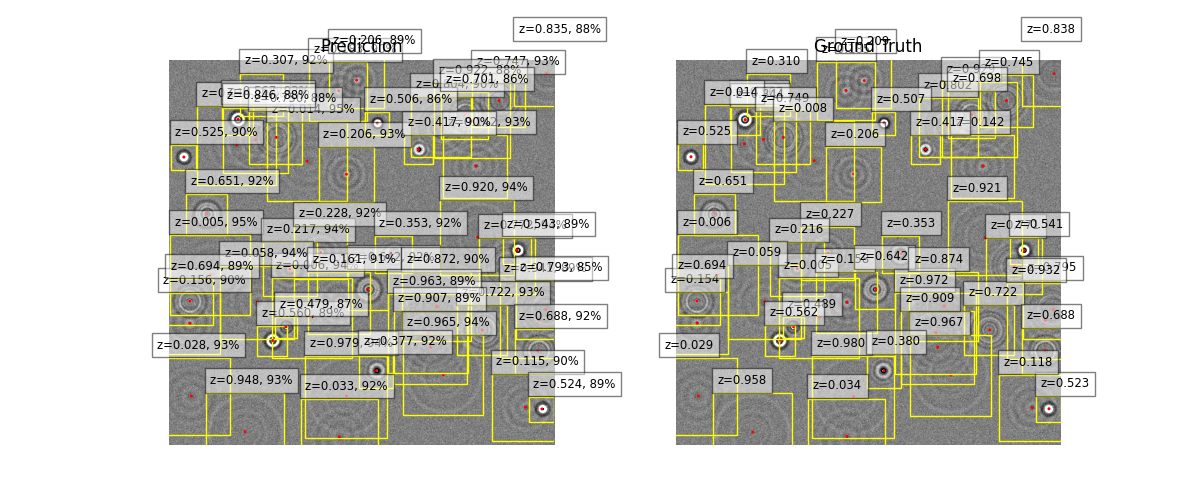

In [33]:
reload(YOLOtrack11)
%matplotlib widget
if not plt.get_fignums() : plt.figure(figsize=(12,5))
else: plt.clf()
image = random_image()
img = np.array(PIL.Image.open(image))#-12768
print(img.shape)
results = model.predict(img)
res = results[0].zaxis.data.cpu().numpy()
# kpts = results[0].keypoints.data.cpu().numpy()
# print(res)
plt.subplot(1,2,1)
plt.title("Prediction")
plot_result(plt.gca(),image,res[:,4],ops.xyxy2xywh(res[:,:4])/512,res[:,6],res[:,7:],conf=res[:,4])
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
gt_bboxes,gt_z_values = plot_gt(image,plt.gca())
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
print("gt  :", gt_z_values[np.where(gt_pred_matcher.T)[1]])
print("yolo:", res[:,-1])
# print("corr:", np.array(corr))
print("gt undetected:", gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]])

plt.show()



In [7]:
results

[YOLOtrack11.results.ZAxisResults object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'b'}
 obb: None
 orig_img: array([[19986, 19991, 20016, ..., 20006, 19990, 19953],
        [19980, 20027, 20010, ..., 20025, 19937, 20040],
        [20028, 20000, 19982, ..., 20036, 20029, 20008],
        ...,
        [19971, 20014, 19979, ..., 20000, 19971, 19990],
        [19986, 19989, 19993, ..., 19992, 19978, 19987],
        [19968, 19980, 19997, ..., 19987, 19980, 20007]], dtype=uint16)
 orig_shape: (512, 512)
 path: 'image0.jpg'
 probs: None
 save_dir: '/home/jupyter-till/git/ultralytics/runs/zaxis/predict'
 speed: {'preprocess': 13.494014739990234, 'inference': 3.2372474670410156, 'postprocess': 0.4734992980957031}
 zaxis: YOLOtrack11.results.ZAxis object]

/tmp/ipykernel_82667/1930840522.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes
/tmp/ipykernel_82667/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)


<Figure size 2000x600 with 0 Axes>

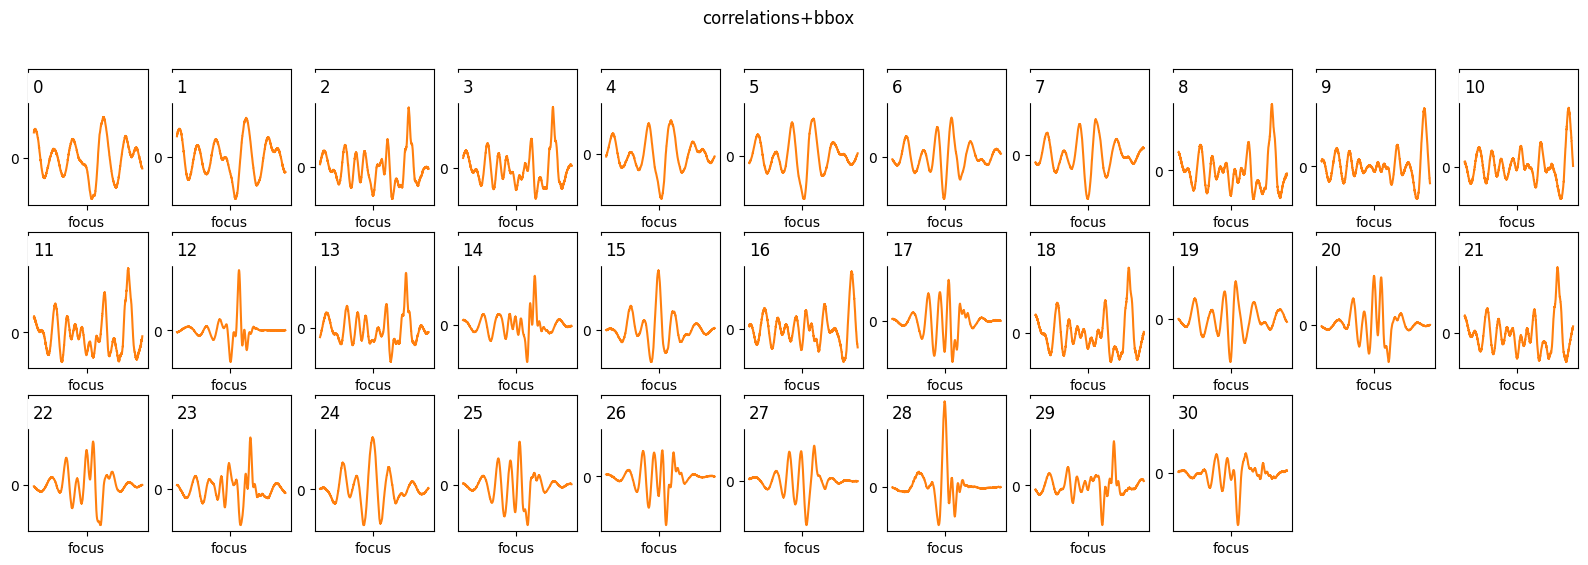

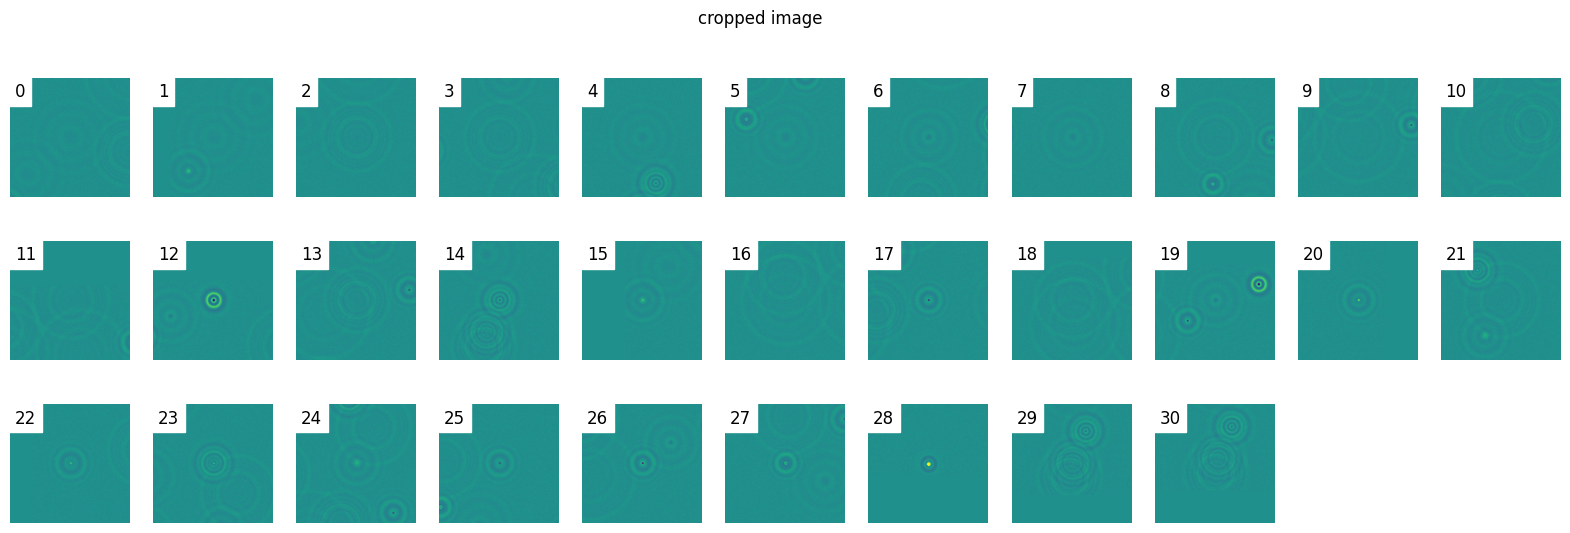

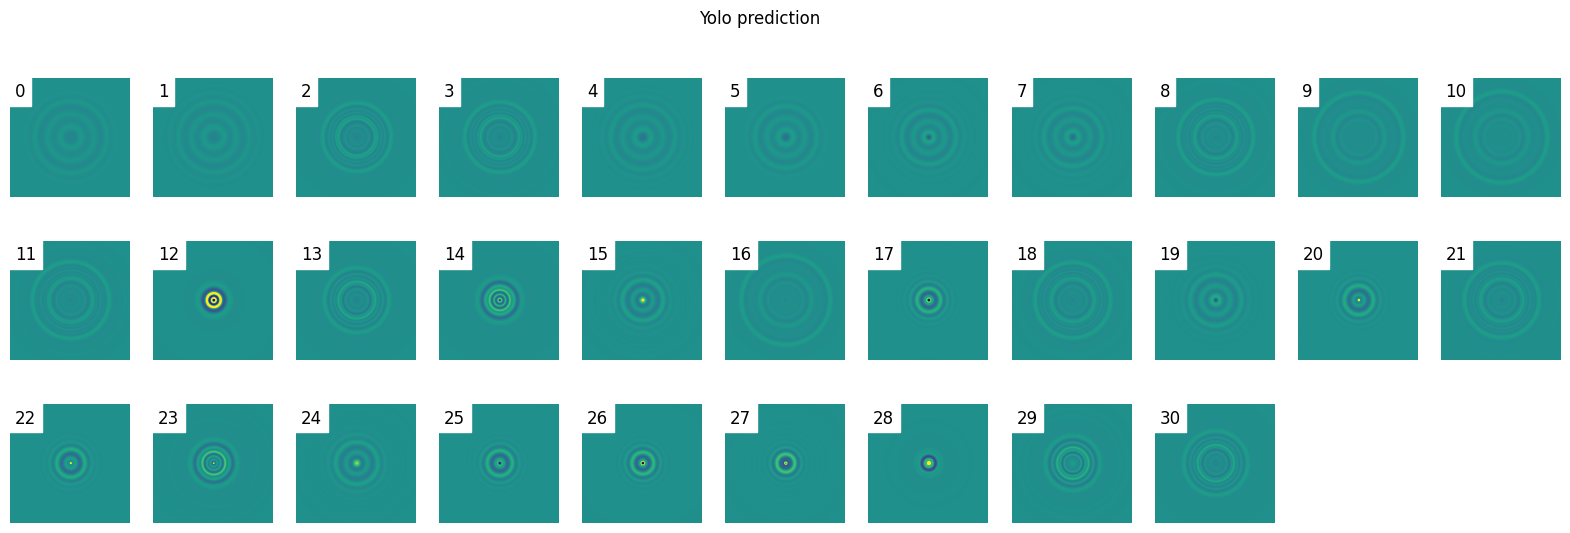

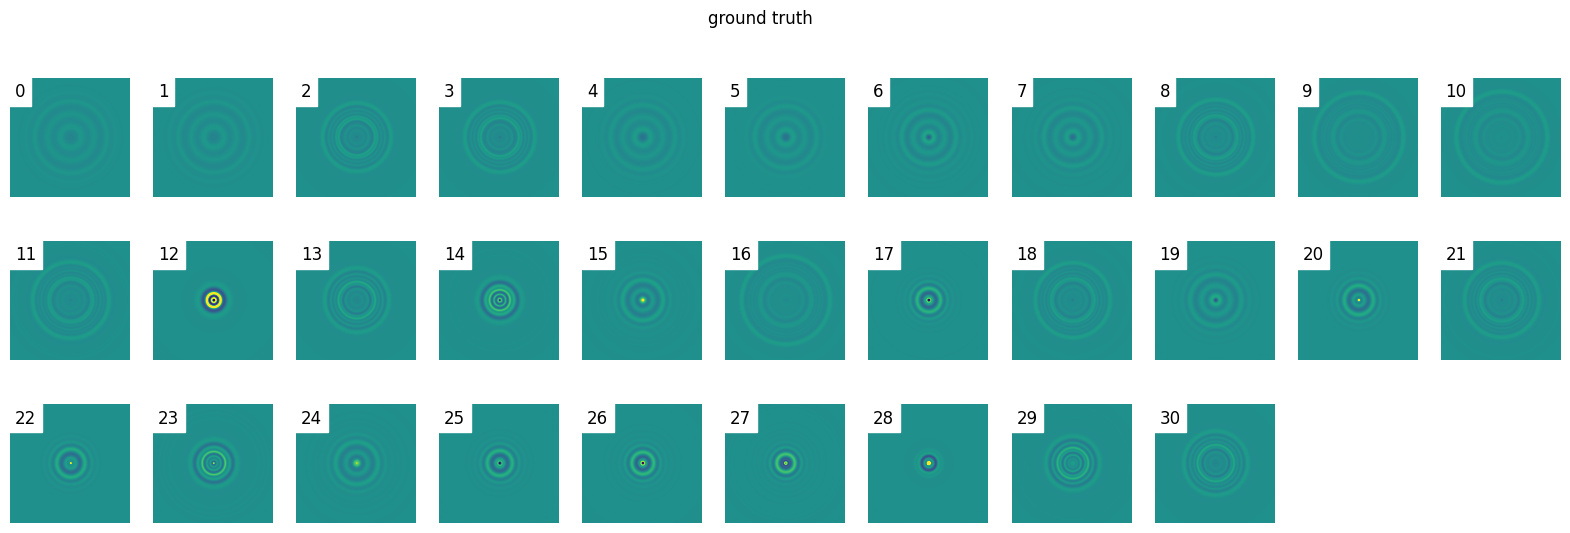

In [4]:
# plt.figure()
# plt.imshow(results[0].orig_img)
# plt.figure(figsize=(20,2))

padding=128
size=128
padded_image = np.pad(results[0].orig_img,padding,mode="constant",constant_values=2e4)

# plt.axis("off")
captures = np.empty((len(res),size,size))
for i,box in enumerate(res):
    # print(box)
    x1,y1,x2,y2,_,_,z,x,y = box
    w,h = x2-x1,y2-y1
    if(x1 == 0):
        x1-=h-w
        w = h
    if(y1 == 0):
        y1-=w-h
        h = w
    if(x2 == 511):
        x2+=h-w
        w = h
    if(y2 == 511):
        y2+=w-h
        h = w
    x,y = 0.5*(x1+x2),0.5*(y1+y2)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    captures[i] = padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2]
# captures/=
# captures-=1
downsampled_reference = (np.load("../ultralytics/data_gen/ripples_downsampled.npy")/10000)-2
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
def bells(x,w,*args):
    f = np.sum([np.exp(-(w*(x-mu)**2)) for mu in args],axis=0)
    return f/np.max(f)
x = np.arange(len(downsampled_reference))
corr = []
for i,capture in enumerate(captures):

    x1,y1,x2,y2,_,_,pred_z,x,y = res[i]
    w,h = x2-x1,y2-y1
    v = (max(w,h)*(2)-55)
    z  = (-v/0.21)+761,(v/0.21)+761
    plt.figure(1)
    plt.suptitle("correlations+bbox")
    correlation = np.pow((downsampled_reference*(capture/10000-2)).sum(axis=(1,2)),1)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.plot(bells(x,5e-4,*z)*(np.max(correlation)-np.min(correlation)))
    plt.plot(correlation)
    # plt.axvline(pred_z*len(downsampled_reference), c="red")
    plt.xticks([761],["focus"])
    plt.yticks([0])
    # plt.ylim(0,0.5)c
    # plt.tight_layout()

    plt.figure(2)
    plt.suptitle("cropped image")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.imshow(capture,vmin=1.85e4,vmax=2.15e4)
    plt.axis("off")
    # plt.tight_layout()
    plt.figure(3)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.suptitle("Yolo prediction")
    plt.imshow(downsampled_reference[np.round(pred_z*len(downsampled_reference)).astype(int)],vmin=-0.05,vmax=0.05)
    plt.axis("off")

    plt.figure(4)
    plt.suptitle("ground truth")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")

    correct_detection = np.where(gt_pred_matcher.T[i])[0]
    # if correct_detection:
    gt_image = (downsampled_reference[np.round(gt_z_values[correct_detection]*len(downsampled_reference)).astype(int)])
    # else:
    #     gt_image = np.zeros((1,128,128))
    plt.imshow(gt_image[0],vmin=-0.05,vmax=0.05)
    plt.axis("off")
    # plt.figure(4)
    # plt.suptitle("image via max correlations+bbox size")

    # plt.subplot(len(captures)//11+1,11,i+1)
    # plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    # plt.imshow(downsampled_reference[np.argmax(correlation*bells(x,5e-4,*z))],vmin=-0.05,vmax=0.05)
    # corr.append(np.argmax(correlation*bells(x,5e-4,*z))/len(downsampled_reference))
    # plt.axis("off")



    # plt.colorbar()



In [13]:
undetected = downsampled_reference[np.round(gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]]).astype(int)]
plt.figure(figsize=(20,2))
for i,img in enumerate(undetected):
    plt.subplot(1,11,i+1)
    plt.imshow(img)
plt.show()

<Figure size 2000x200 with 0 Axes>